In [1]:
from src import *
# from src.convergence_analysis import *
import scipy.sparse.linalg as spsl
# from src.quantum import *
from qiskit.quantum_info import SparsePauliOp
import pickle
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Hamiltonian Parameters
num_qubits = 15
h = 1
J = 1

# Algorithm Parameters
max_energy_level = 4
kd_ratio = 2.5
noise_threshold = 1e-2
epsilon = 1e-3
K_values = list(range(200))
delta_t = 0.083
num_modmd_observables = 6
num_trials = 5

In [3]:
# Construct Hamiltonian
xx_strings = ['I' * i + 'ZZ' + 'I'* (num_qubits - i - 2) for i in range(num_qubits-1)]
z_strings = ['I' * i + 'X' + 'I'* (num_qubits - i - 1) for i in range(num_qubits)]
sparse_tfim_hamiltonian = SparsePauliOp.from_list([(s,-J) for s in xx_strings] + [(s,-h) for s in z_strings]).to_matrix(sparse=True)

# Get true eigenenergies
true_eigenenergies = spsl.eigsh(sparse_tfim_hamiltonian,k=max_energy_level+1,which = 'SA')[0]

In [4]:
# Construct reference state
indices = np.argsort(sparse_tfim_hamiltonian.diagonal())
reference_state = bitstring_superposition_state(num_qubits,[bin(indices[i])[2:] for i in range(6)])

# Get evolved reference states
max_K = K_values[-1]
max_d = int(max_K/kd_ratio)
time_evolution_operator = -1j*sparse_tfim_hamiltonian*delta_t
evolved_reference_states = spsl.expm_multiply(time_evolution_operator,reference_state,start=0,stop=max_d+max_K+1,num = max_d+max_K+2)

In [5]:
# Load/generate observable set FIX THIS
try: 
    with open(f'Data/Observable Sets/one_local_paulis_{num_qubits}_qubits.pkl', 'rb') as f:
        modmd_observable_set = pickle.load(f)

except:
    modmd_observable_set = all_one_local_paulis(num_qubits)
    with open(f'Data/Observable Sets/one_local_paulis_{num_qubits}_qubits.pkl', 'wb') as f:
        pickle.dump(modmd_observable_set, f)

In [6]:
# ODMD Results
observables = [SparsePauliOp('I' * num_qubits).to_matrix(sparse=True)]
odmd_results = []

X_elements = generate_X_elements(observables,max_d,max_K,reference_state,evolved_reference_states)

for trial in range(num_trials):

    print(f'Trial {trial+1}')
    
    gaussian_noise = np.random.normal(0,epsilon,size=X_elements.shape) + 1j * np.random.normal(0,epsilon,size=X_elements.shape)
    noisy_X_elements = X_elements + gaussian_noise

    odmd_results.append(varying_K_results(len(observables),noise_threshold,noisy_X_elements,delta_t,K_values,kd_ratio,max_energy_level))
    

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5


In [7]:
# MODMD Results
modmd_results = []

for trial in range(num_trials):
    print(f'Trial {trial+1}')
    
    observables = np.random.choice(modmd_observable_set,num_modmd_observables,replace=False)

    X_elements = generate_X_elements(observables,max_d,max_K,reference_state,evolved_reference_states)
    gaussian_noise = np.random.normal(0,epsilon,size=X_elements.shape) + 1j * np.random.normal(0,epsilon,size=X_elements.shape)
    noisy_X_elements = X_elements + gaussian_noise

    modmd_results.append(varying_K_results(len(observables),noise_threshold,noisy_X_elements,delta_t,K_values,kd_ratio,max_energy_level))

Trial 1
Trial 2
Trial 3
Trial 4
Trial 5


In [8]:
# Compute errors
absolute_odmd_errors = np.array([np.abs(odmd_results[i] - true_eigenenergies) for i in range(num_trials)])
absolute_modmd_errors = np.array([np.abs(modmd_results[i] - true_eigenenergies) for i in range(num_trials)])

/Users/alexbuzali/anaconda3/envs/modmd_env/lib/python3.12/site-packages/numpy/_core/_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Text(0, 0.5, 'Absolute Error')

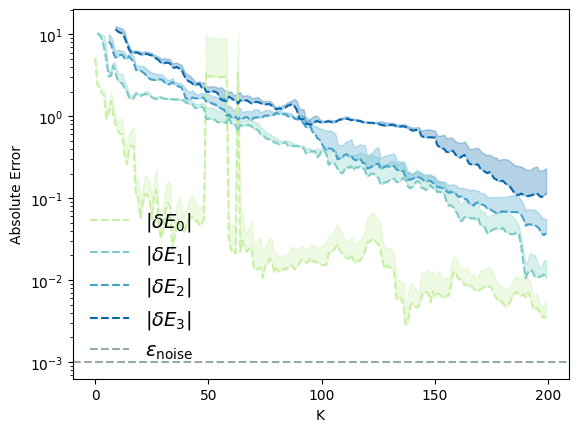

In [9]:
# Plotting
energyLevels = [0,1,2,3]
errorType = 'Absolute'
algorithm = 'MODMD'
colors = ['#c8f0a5','#7bccc4','#43a2ca','#0868ac']
labels = [r'$|\delta E_0|$',r'$|\delta E_1|$',r'$|\delta E_2|$',r'$|\delta E_3|$']

for i, energyLevel in enumerate(energyLevels):

    if algorithm == 'ODMD':
        odmd_average = np.average(absolute_odmd_errors,0)[:,energyLevel]
        odmd_std = np.std(absolute_odmd_errors,0)[:,energyLevel]
        plt.semilogy(K_values, odmd_average, '--', color = colors[i], label = labels[i])
        plt.fill_between(K_values,odmd_average,odmd_average + odmd_std,color = colors[i],alpha = .3)
    elif algorithm == 'MODMD':
        modmd_average = np.average(absolute_modmd_errors,0)[:,energyLevel]
        modmd_std = np.std(absolute_modmd_errors,0)[:,energyLevel]
        plt.semilogy(K_values,modmd_average, '--',color = colors[i],label = labels[i])
        plt.fill_between(K_values,modmd_average,modmd_average + modmd_std,color = colors[i],alpha = .3)

matplotlib.rcParams.update({'font.size': 14})
plt.axhline(epsilon, color = '#95ab9b', linestyle = '--', label = r'$\epsilon_\text{noise}$')
plt.legend(framealpha = 0, fontsize=14)
plt.xlabel('K')
plt.ylabel(r'Absolute Error')